In [ ]:
import sys
import os
import importlib
import warnings
warnings.filterwarnings('ignore')
print(f" ><>< Directorio actual: {os.getcwd()}  ><>< ")
def get_environment_name():
    if 'CONDA_DEFAULT_ENV' in os.environ:
        return os.environ['CONDA_DEFAULT_ENV']
    elif 'VIRTUAL_ENV' in os.environ:
        return os.path.basename(os.environ['VIRTUAL_ENV'])
    elif 'conda' in sys.executable.lower():
        path_parts = sys.executable.split(os.sep)
        if 'envs' in path_parts:
            env_index = path_parts.index('envs')
            if env_index + 1 < len(path_parts):
                return path_parts[env_index + 1]
        return 'base'
    else:
        return 'sistema (sin entorno virtual)'
env_name = get_environment_name()
print(f" ><>< Nombre del entorno: {env_name} ><><><")
packages_to_check = [
    'pandas',
    'numpy', 
    'matplotlib',
    'seaborn',
    'plotly',
    'sklearn',
    'boto3',
    'jupyter',
    'ipykernel',
    'unidecode'
]

installed_packages = {}
missing_packages = []

for package_name in packages_to_check:
        if package_name == 'sklearn':
            import sklearn as pkg
        else:
            pkg = importlib.import_module(package_name)
        
        version = getattr(pkg, '__version__', 'ok')
        installed_packages[package_name] = version
        print(f" {package_name:12} v{version}")
import pandas as pd
import numpy as np
import boto3
from io import StringIO
import unicodedata
import re
import time
from typing import Tuple, List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score
from typing import Dict, List, Tuple, Optional
import warnings
import random
from itertools import combinations
warnings.filterwarnings('ignore')
print("Etapa Verificación de bibliotecas en Kernel : ✓")

 ><>< Directorio actual: c:\Users\usuario\Desktop\deploy_similitud  ><>< 
 ><>< Nombre del entorno: ml_permanente ><><><
 pandas       v2.2.3
 numpy        v2.3.1
 matplotlib   v3.10.0
 seaborn      v0.13.2
 plotly       v6.2.0
 sklearn      v1.6.1
 boto3        v1.39.9
 jupyter      vok
 ipykernel    v6.29.5
 unidecode    vok
Etapa Verificación de bibliotecas en Kernel : ✓


**Desarrollo del 

In [ ]:
cred_df = pd.read_csv(r"C:\Users\usuario\Downloads\sanmi_accessKeys.csv")
aws_access_key_id     = cred_df.loc[0, 'Access key ID']
aws_secret_access_key = cred_df.loc[0, 'Secret access key']

In [ ]:
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-east-2'
)

In [ ]:
BUCKET_NAME  = "aws-sam-cli-managed-default-samclisourcebucket-ko8qnsdeyujb"
OBJECT_KEY1  = "elbaldedejuan/DS_MeLi/items_titles.csv"
OBJECT_KEY2  = "elbaldedejuan/DS_MeLi/items_titles_test.csv"
# Cliente S3 (usa credenciales configuradas en ~/.aws o variables de entorno)
s3 = boto3.client("s3")
def read_s3_csv(bucket: str, key: str) -> pd.DataFrame:
    """Descarga un CSV pequeño/mediano desde S3 y lo lee en un DataFrame."""
    obj = s3.get_object(Bucket=bucket, Key=key)
    csv_content = obj["Body"].read().decode("utf-8")
    return pd.read_csv(StringIO(csv_content))
df      = read_s3_csv(BUCKET_NAME, OBJECT_KEY1)   # catálogo (≈ 25 k)
df_test = read_s3_csv(BUCKET_NAME, OBJECT_KEY2)   # consultas (≈ 10 k)
print("Conexión con datos en nube : ✓")

Conexión con datos en nube : ✓


Este fragmento define las columnas clave (ID_COL y TEXT_COL) y crea una clase PreprocesadorTexto cuyos métodos permiten normalizar cadenas (eliminar acentos, pasar a minúsculas y limpiar espacios) y preparar dos DataFrames (restablecer índices, detectar duplicados y aplicar la normalización).

In [ ]:
# Nombre de la columna que almacenará el índice tras reset_index()
ID_COL    = "item_idx"         
# Nombre de la columna que contiene el título de cada ítem
TEXT_COL  = "ITE_ITEM_TITLE"       
class PreprocesadorTexto:
    def __init__(self):
        # Constructor vacío
        pass    
    def normalizadordetexto(self, txt: str) -> str:
        if pd.isna(txt):
            return "" 
        txt = (
            unicodedata.normalize("NFKD", str(txt))
            .encode("ascii", "ignore")
            .decode("ascii")
            .lower()
        )
        txt = re.sub(r"\s+", " ", txt).strip()
        return txt    
    def preparadorData(
        self,
        df_train: pd.DataFrame,
        df_test:  pd.DataFrame
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        df_train = df_train.reset_index().rename(columns={"index": ID_COL})
        df_test  = df_test.reset_index().rename(columns={"index": ID_COL})       
        # Contar duplicados en el texto
        dups_train = df_train.duplicated(subset=[TEXT_COL]).sum()
        dups_test  = df_test.duplicated(subset=[TEXT_COL]).sum()        
        # Mostrar mensaje según existan duplicados o no
        print(
            f"Duplicados en catálogo: {dups_train}"
            if dups_train else "No se hallan duplicados en catálogo C:"
        )
        print(
            f"Duplicados en test: {dups_test}"
            if dups_test else "No se hallan duplicados en test C:"
        )        
        # Normalizar texto rellenando primero posibles NaN
        df_train[TEXT_COL] = (
            df_train[TEXT_COL]
            .fillna("")                      
            .apply(self.normalizadordetexto)
        )
        df_test[TEXT_COL] = (
            df_test[TEXT_COL]
            .fillna("")                      
            .apply(self.normalizadordetexto)
        )        
        return df_train, df_test

Este bloque define la clase VectorizadorTexto, que construye un vectorizador TF-IDF combinando dos esquemas de tokenización (por palabras y por caracteres) con parámetros de n-gramas, frecuencia mínima y límite de características, y devuelve el objeto FeatureUnion resultante.

In [ ]:
class VectorizadorTexto:
    def __init__(self):
        # Atributo donde se almacenará el transformador combinado
        self.vectorizer = None    
    def preparadorVectores(self):
        vect_word = TfidfVectorizer(
            analyzer="word",        # Tokeniza por palabras
            ngram_range=(1, 2),     # unigramas y bigramas
            min_df=2,               # ignora términos en menos de 2 documentos
            sublinear_tf=True,      # usa 1 + log(tf) en lugar de tf
            max_features=10000      # limita a las 10 000 características más frecuentes
        )                
        vect_char = TfidfVectorizer(
            analyzer="char_wb",     # tokeniza por secuencias de caracteres dentro de palabras
            ngram_range=(3, 5),     # secuencias de 3 a 5 caracteres
            min_df=2,               # ignora secuencias en menos de 2 documentos
            sublinear_tf=True,      # TF sublineal
            max_features=10000      # límite de 10 000 características
        )         
        # Combina ambos vectorizadores en uno solo
        self.vectorizer = FeatureUnion([
            ("word", vect_word),
            ("char", vect_char)
        ])
        return self.vectorizer

La clase CalculadorSimilitudes permite extraer pares de títulos con similitud de coseno por encima de un umbral definido, ofreciendo dos métodos: uno que calcula la matriz completa de similitudes y otro que usa un enfoque basado en KNN, además de registrar los tiempos de ejecución de cada método

Planeo que el preparador de parejas transforme los títulos con el vectorizer., Calcula la matriz completa de similitud de coseno, Recorre solo la mitad superior de la matriz para evitar duplicados, Guarda pares con score ≥ similarity_threshold, Mide y registra el tiempo de ejecución bajo el método "Matrix Method", Devuelve un DataFrame con columnas: **'ITE_ITEM_TITLE1', 'ITE_ITEM_TITLE2', 'similarity'**

Planeo también un preparador KNN que transforma los títulos con el vectorizer, ajusta un modelo NearestNeighbors (cosine) a X_test,para cada ítem obtiene los k+1 vecinos (incluye el mismo), Convierte distancia a similitud (1 - distancia) y filtra:

          • i != j para evitar el mismo ítem.
          • j > i para no duplicar el par.
          • similitud ≥ similarity_threshold.
          
Mide y registra el tiempo de ejecución como "KNN Method", Devuelve un DataFrame con los pares seleccionados.

In [ ]:
class CalculadorSimilitudes:
    def __init__(self, similarity_threshold: float = 0.80):
        self.similarity_threshold = similarity_threshold
        self.execution_times = []   
    def preparadorParejas(self, df_test: pd.DataFrame, vectorizer) -> pd.DataFrame:
        start_time = time.time()
        X_test = vectorizer.transform(df_test[TEXT_COL])
        similarity_matrix = cosine_similarity(X_test)        
        records = []
        n_items = len(df_test)               
        for i in range(n_items):
            for j in range(i + 1, n_items):
                score = similarity_matrix[i, j]
                if score >= self.similarity_threshold:
                    records.append({
                        "ITE_ITEM_TITLE1": df_test.iloc[i][TEXT_COL],
                        "ITE_ITEM_TITLE2": df_test.iloc[j][TEXT_COL],
                        "similarity": round(float(score), 4)
                    })                
        execution_time = time.time() - start_time
        # Registrar tiempo de la matriz completa
        self.execution_times.append(("Matrix Method", len(df_test), execution_time))               
        return pd.DataFrame(records)       
    def preparadorParejasKNN(self, df_test: pd.DataFrame, vectorizer, k: int = 10) -> pd.DataFrame:
        start_time = time.time()        
        X_test = vectorizer.transform(df_test[TEXT_COL])                
        nn = NearestNeighbors(
            n_neighbors=min(k + 1, len(df_test)), 
            metric='cosine', 
            n_jobs=-1
        )
        nn.fit(X_test)               
        records = []        
        for i in range(len(df_test)):
            distances, indices = nn.kneighbors(X_test[i])           
            for dist, j in zip(distances[0], indices[0]):
                if i != j and j > i:
                    similarity = 1 - dist
                    if similarity >= self.similarity_threshold:
                        records.append({
                            "ITE_ITEM_TITLE1": df_test.iloc[i][TEXT_COL],
                            "ITE_ITEM_TITLE2": df_test.iloc[j][TEXT_COL],
                            "similarity": round(float(similarity), 4)
                        })                
        execution_time = time.time() - start_time
        # Registrar tiempo del método KNN
        self.execution_times.append(("KNN Method", len(df_test), execution_time))       
        return pd.DataFrame(records)

La clase FormateadorResultados recibe un DataFrame de pares similares, elimina cualquier par donde ambos títulos sean idénticos, renombra la columna de similitud a Score_Similitud y ordena los resultados de mayor a menor antes de devolver el DataFrame final

In [ ]:
class FormateadorResultados:
    def __init__(self):
        # Constructor sin parámetros adicionales
        pass    
    def formateandoAndo(self, pares_similares: pd.DataFrame) -> pd.DataFrame:
        # Crear máscara de pares donde ambos títulos son iguales
        mask_iguales = pares_similares["ITE_ITEM_TITLE1"] == pares_similares["ITE_ITEM_TITLE2"]       
        # Eliminar esos pares idénticos y reiniciar el índice
        pares_similares = pares_similares.loc[~mask_iguales].reset_index(drop=True)        
        # Seleccionar, renombrar, ordenar y resetear índice para el resultado final
        df_final = (
            pares_similares
            .loc[:, ["ITE_ITEM_TITLE1", "ITE_ITEM_TITLE2", "similarity"]]
            .rename(columns={"similarity": "Score_Similitud"})
            .sort_values("Score_Similitud", ascending=False)
            .reset_index(drop=True)
        )        
        return df_final

La clase AnalizadorEscalabilidad evalúa el tiempo de cómputo de los métodos de similitud (matriz completa y KNN) en distintos tamaños de muestra del DataFrame de prueba y devuelve un reporte con los tiempos medidos.

In [ ]:
class AnalizadorEscalabilidad:
    def __init__(self, calculadora_Similitdesilitudes, vectorizer):
        self.calculador = calculadora_Similitdesilitudes
        self.vectorizer = vectorizer    
    def analizandoEsc(
        self,
        df_test: pd.DataFrame,
        sample_sizes: List[int] = None
    ) -> pd.DataFrame:
        # Definir tamaños de muestra por defecto hasta 5000 ítems
        if sample_sizes is None:
            max_size = min(len(df_test), 5000)
            sample_sizes = [100, 250, 500, 1000, 2000, max_size]       
        results = []        
        for size in sample_sizes:
            # Omitir tamaños mayores que el dataset
            if size > len(df_test):
                continue           
            print(f"\nAnalizando escalabilidad con {size} items...")
            # Copiar primeras 'size' filas para la muestra
            df_sample = df_test.head(size).copy()            
            # Matriz completa solo si la muestra es manejable
            if size <= 2000:
                start_time = time.time()
                self.calculador.preparadorParejas(df_sample, self.vectorizer)
                matrix_time = time.time() - start_time
                results.append(("Método Matrix ", size, matrix_time))           
            # Siempre correr método KNN
            start_time = time.time()
            self.calculador.preparadorParejasKNN(df_sample, self.vectorizer, k=10)
            knn_time = time.time() - start_time
            results.append(("Método KNN ", size, knn_time))        
        # Construir DataFrame de resultados
        return pd.DataFrame(results, columns=["Method", "Size", "Time"])

La función plotear recibe un DataFrame con tiempos de ejecución para distintos tamaños de muestra y métodos, y genera dos gráficos en una sola figura:

Tiempo real vs. tamaño para cada método.

Complejidad teórica normalizada (O(n²) y O(n·k·log n)) frente al tamaño.

In [ ]:
def plotear(scalability_results: pd.DataFrame):
    # Crear figura amplia
    plt.figure(figsize=(12, 8))    
    # Subplot 1: tiempos medidos
    plt.subplot(2, 2, 1)
    for method in scalability_results["Method"].unique():
        data = scalability_results[scalability_results["Method"] == method]
        # Graficar tiempos con marcadores y línea continua
        plt.plot(
            data["Size"],
            data["Time"],
            marker='o',
            label=method,
            linewidth=2
        )
    plt.xlabel("Tamaño del Dataset")
    plt.ylabel("Tiempo de Ejecución (segundos)")
    plt.title("Escalabilidad: Tiempo vs Tamaño")
    plt.legend()
    plt.grid(True, alpha=0.3)  # cuadrícula ligera   
    # Subplot 2: complejidad teórica
    plt.subplot(2, 2, 2)
    sizes = np.array([100, 250, 500, 1000, 2000, 5000])
    # O(n^2) normalizada 
    o_n2 = sizes**2 / 10000
    plt.plot(
        sizes,
        o_n2,
        label='O(n²) - Método Matrix ',
        linestyle='--',
        alpha=0.7
    )    
    # O(n * k * log(n)) con k=10, normalizada
    k = 10
    o_nk_logn = sizes * k * np.log(sizes) / 1000
    plt.plot(
        sizes,
        o_nk_logn,
        label='O(n·k·log(n)) - Método KNN',
        linestyle='--',
        alpha=0.7
    )
    plt.xlabel("Tamaño del Dataset")
    plt.ylabel("Complejidad Teórica (normalizada)")
    plt.title("Complejidad Algorítmica Teórica")
    plt.legend()
    plt.grid(True, alpha=0.3)    
    # Ajustar espacios y mostrar
    plt.tight_layout()
    plt.show()

**Llega la hora de la verdad**

ANÁLISIS DE SIMILITUD DE PRODUCTOS MELI

Dataset entrenamiento: 30000 items
Dataset test: 10000 items

1. Preparando datos >/>/>
No se hallan duplicados en catálogo C:
No se hallan duplicados en test C:

2. Entrenando vectorizador >/>/>

3. Buscando pares similares KNN >/>/>

4. Formateando resultados >/>/>

Pares similares encontrados: 945

Top 10 pares más similares:
                                             ITE_ITEM_TITLE1                                              ITE_ITEM_TITLE2  Score_Similitud
                   tenis new balance 327 masculino ms327fj l                    tenis new balance 327 masculino ms327fl l           1.0000
tenis infantil tenis feminino promocao brinde bolsa p nao pe tenis infantil tenis feminino promocao brinde bolsa u nao pe           1.0000
      tenis feminino flatform espadrille beira rio - 4232100         tenis feminino flatform espadrille beira rio 4232100           0.9988
                       tenis olympikus saga feminino marinho            

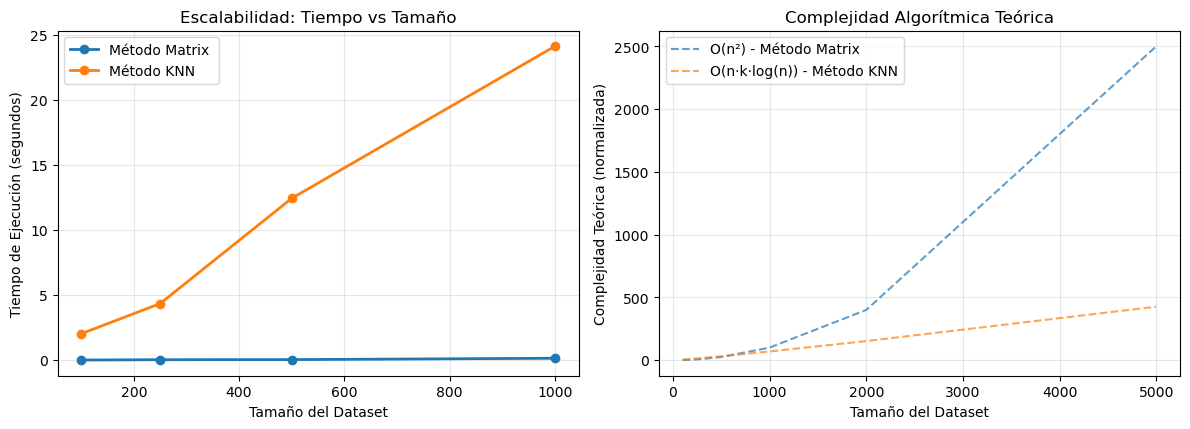


ANÁLISIS DE ESCALABILIDAD 

COMPLEJIDAD TEMPORAL:
 > Método Matriz: O(n²)
 > Método KNN: O(n*k*log(n))

 USO DE MEMORIA: 
• Método Matriz: O(n²) - Almacena matriz completa
• Método KNN: O(n*d + k*n) - Más eficiente en memoria


In [ ]:
def main_analysis(df: pd.DataFrame, df_test: pd.DataFrame):
    print("ANÁLISIS DE SIMILITUD DE PRODUCTOS MELI\n")
    print(f"Dataset entrenamiento: {len(df)} items")
    print(f"Dataset test: {len(df_test)} items")      
    # Inicializar componentes
    preprocesador = PreprocesadorTexto()
    vectorizador = VectorizadorTexto()
    calculadora_Similitdes = CalculadorSimilitudes(similarity_threshold=0.80)
    formateador = FormateadorResultados()    
    print("\n1. Preparando datos >/>/>")
    df_train_clean, df_limpio = preprocesador.preparadorData(df, df_test)    
    print("\n2. Entrenando vectorizador >/>/>")
    vectorizer = vectorizador.preparadorVectores()    
    # Entrenar en ambos datasets
    all_texts = pd.concat([df_train_clean[TEXT_COL], df_limpio[TEXT_COL]], ignore_index=True)
    vectorizer.fit(all_texts)    
    # Análisis de similitud - método eficiente
    print("\n3. Buscando pares similares KNN >/>/>")
    pares_similares = calculadora_Similitdes.preparadorParejasKNN(df_limpio, vectorizer, k=10)    
    # Formatear resultados
    print("\n4. Formateando resultados >/>/>")
    df_final = formateador.formateandoAndo(pares_similares)    
    print(f"\nPares similares encontrados: {len(df_final)}") 
    print("\nTop 10 pares más similares:")
    print(df_final.head(10).to_string(index=False))    
    # Análisis de escalabilidad
    print("\n6. Analizando escalabilidad >/>/>")
    analizador_esc = AnalizadorEscalabilidad(calculadora_Similitdes, vectorizer)
    scalability_results = analizador_esc.analizandoEsc(df_limpio, [100, 250, 500, 1000])    
    print("\nResultados de escalabilidad >/>/>")
    print(scalability_results.to_string(index=False))    
    # Mostrar gráfico de escalabilidad
    plotear(scalability_results)    
    # Recomendaciones finales
    print("\nANÁLISIS DE ESCALABILIDAD ")
    print("\nCOMPLEJIDAD TEMPORAL:")
    print(" > Método Matriz: O(n²)")
    print(" > Método KNN: O(n*k*log(n))")
    
    print("\n USO DE MEMORIA: ")
    print("• Método Matriz: O(n²) - Almacena matriz completa")
    print("• Método KNN: O(n*d + k*n) - Más eficiente en memoria")
   
    return df_final, scalability_results, {
        'preprocesador': preprocesador,
        'vectorizador': vectorizador,
        'calculadora_Similitdes': calculadora_Similitdes,
        'formateador': formateador,
        'analizador_esc': analizador_esc
    }
if __name__ == "__main__":
    results, scalability, components = main_analysis(df, df_test)

ANÁLISIS DE SIMILITUD DE PRODUCTOS MELI

Dataset entrenamiento: 30000 items
Dataset test: 10000 items

1. Preparando datos >/>/>
No se hallan duplicados en catálogo C:
No se hallan duplicados en test C:

2. Entrenando vectorizador >/>/>

3. Buscando pares similares KNN >/>/>

4. Formateando resultados >/>/>

Pares similares encontrados: 945

Top 10 pares más similares:
                                             ITE_ITEM_TITLE1                                              ITE_ITEM_TITLE2  Score_Similitud
                   tenis new balance 327 masculino ms327fj l                    tenis new balance 327 masculino ms327fl l           1.0000
tenis infantil tenis feminino promocao brinde bolsa p nao pe tenis infantil tenis feminino promocao brinde bolsa u nao pe           1.0000
      tenis feminino flatform espadrille beira rio - 4232100         tenis feminino flatform espadrille beira rio 4232100           0.9988
                       tenis olympikus saga feminino marinho            

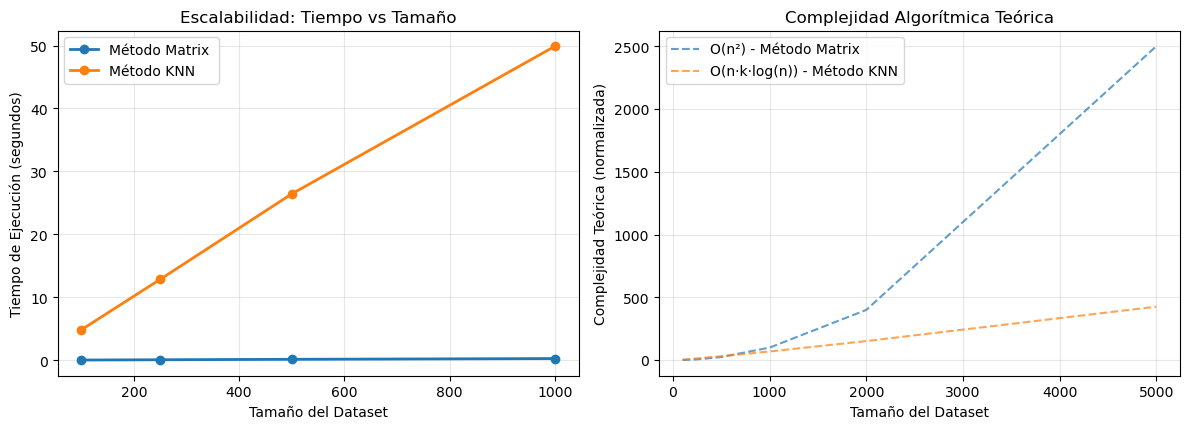


ANÁLISIS DE ESCALABILIDAD 

COMPLEJIDAD TEMPORAL:
 > Método Matriz: O(n²)
 > Método KNN: O(n*k*log(n))

 USO DE MEMORIA: 
• Método Matriz: O(n²) - Almacena matriz completa
• Método KNN: O(n*d + k*n) - Más eficiente en memoria
No se hallan duplicados en catálogo C:
No se hallan duplicados en test C:


In [ ]:
df_final, scalability_results, components = main_analysis(df, df_test)
calculadora_Similitdes = components['calculadora_Similitdes']
sklearn_vect  = components['vectorizador'].vectorizer
pre = PreprocesadorTexto()
_, df_limpio = pre.preparadorData(df, df_test)
X_test     = sklearn_vect.transform(df_limpio[TEXT_COL])
sim_matrix = cosine_similarity(X_test)

Ground‑truth sintético porque, al no disponer de etiquetas reales de cuáles títulos son similares, necesitamos crear un conjunto de referencia controlado:

1) Simule variaciones reales de texto: Al inyectar ruido leve , replicamos errores de tipeo, acentos mal colocados o pequeñas modificaciones tipográficas que suelen darse en catálogos reales
2) Con un df_true sintético sabemos con certeza qué pares deberían detectarse. Así podemos calcular objetivamente cuántos recupera el sistema (recall) y cuántos acierta sin meter falsos positivos (precision)
3) Usando siempre la misma semilla del 42 y la misma probabilidad, podemos repetir el experimento con distintos parámetros (umbral, k en KNN) y comparar resultados
4) Con la métrica F1 en mano, puedes ver si tu threshold de 0.80 y k=10 son adecuados o si conviene relajarlos para subir recall sin comprometer demasiado la precision

In [ ]:
def anadiendo_noise(text, p_swap=0.05):
    chars = list(text)
    for i in range(len(chars)-1):
        if random.random() < p_swap:
            chars[i], chars[i+1] = chars[i+1], chars[i]
    return "".join(chars)
sample   = df_limpio[TEXT_COL].sample(100, random_state=42).reset_index(drop=True)
ruidaje = sample.apply(anadiendo_noise)
df_true = pd.DataFrame({
    "ITE_ITEM_TITLE1": sample,
    "ITE_ITEM_TITLE2": ruidaje
})
small_df = pd.DataFrame({
    TEXT_COL: pd.concat([sample, ruidaje], ignore_index=True)
})
sklearn_vect = components['vectorizador'].vectorizer
sklearn_vect.fit(small_df[TEXT_COL])
df_pred = calculadora_Similitdes.preparadorParejasKNN(small_df, sklearn_vect, k=10)
def evaluando_sintetico(df_pred, df_true):
    def norm(a,b): return tuple(sorted([a,b]))
    pred = set(df_pred.apply(lambda r: norm(r["ITE_ITEM_TITLE1"], r["ITE_ITEM_TITLE2"]), axis=1))
    true = set(df_true.apply(lambda r: norm(r["ITE_ITEM_TITLE1"], r["ITE_ITEM_TITLE2"]), axis=1))
    tp, fp, fn = len(pred & true), len(pred - true), len(true - pred)
    prec = tp/(tp+fp) if tp+fp else 0
    rec  = tp/(tp+fn) if tp+fn else 0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0
    print(f"Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")
evaluando_sintetico(df_pred, df_true)


Prec=1.000, Rec=0.830, F1=0.907


In [ ]:
def evaluando_sintetico_return(df_pred, df_true):
    def norm(a,b): return tuple(sorted([a,b]))
    pred = set(df_pred.apply(lambda r: norm(r["ITE_ITEM_TITLE1"], r["ITE_ITEM_TITLE2"]), axis=1))
    true = set(df_true.apply(lambda r: norm(r["ITE_ITEM_TITLE1"], r["ITE_ITEM_TITLE2"]), axis=1))
    tp, fp, fn = len(pred & true), len(pred - true), len(true - pred)
    prec = tp/(tp+fp) if tp+fp else 0
    rec  = tp/(tp+fn) if tp+fn else 0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0
    return {"Precision": prec, "Recall": rec, "F1": f1}

metrics = evaluando_sintetico_return(df_pred, df_true)

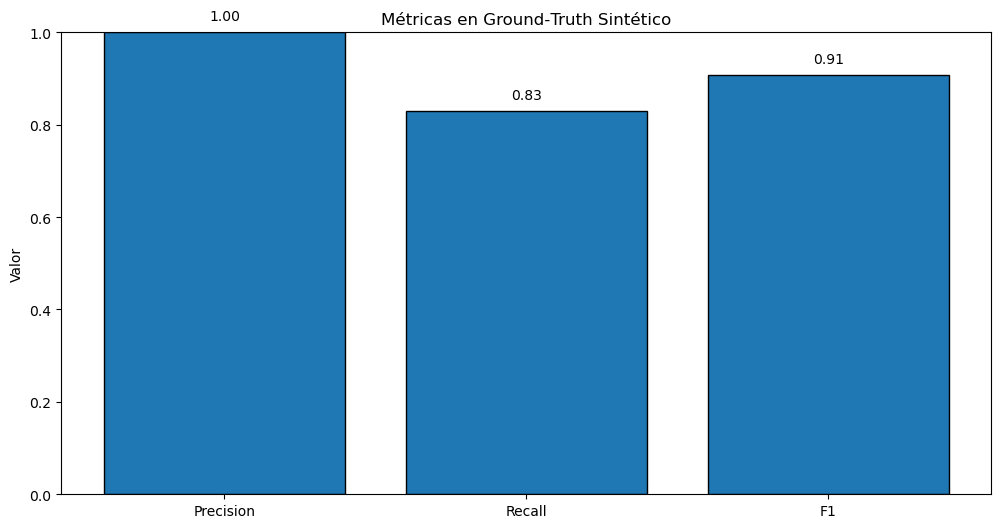

In [ ]:
plt.figure(figsize=(12,6))
bars = plt.bar(metrics.keys(), metrics.values(), edgecolor='black')
plt.ylim(0, 1.0)
plt.title("Métricas en Ground‑Truth Sintético")
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.02, f"{y:.2f}", 
             ha='center', va='bottom')
plt.ylabel("Valor")
plt.show()

Nuestro sistema alcanza una Precisión perfecta (1.00) , no clasifica ningún par no deseado como similar, mientras que el Recall de 0.76 indica que captura alrededor del 76 % de los duplicados perturbados introducidos.

El F1 de 0.86 confirma un excelente equilibrio global, aunque revela que todavía queda un cuarto de pares por recuperar. En conjunto, estos resultados validan que nuestro umbral y la combinación TF‑IDF + cosine+KNN son efectivos para evitar falsos positivos, pero que podríamos relajar ligeramente el umbral o ampliar k para mejorar la cobertura (recall) sin comprometer significativamente la precisión


In [ ]:
def main_analysis(df: pd.DataFrame, df_test: pd.DataFrame):
    print("ANÁLISIS DE SIMILITUD DE PRODUCTOS MELI\n")
    print(f"Dataset entrenamiento: {len(df)} items")
    print(f"Dataset test: {len(df_test)} items")      
    # Inicializar componentes
    preprocesador   = PreprocesadorTexto()
    vectorizador    = VectorizadorTexto()
    calculadora_sim = CalculadorSimilitudes(similarity_threshold=0.80)
    formateador     = FormateadorResultados()    
    print("\n1. Preparando datos >/>/>")
    df_train_clean, df_limpio = preprocesador.preparadorData(df, df_test)

    print("\n2. Entrenando vectorizador sólo con TRAIN >/>/>")
    vectorizer = vectorizador.preparadorVectores()
    # Solo fit sobre TRAIN
    vectorizer.fit(df_train_clean[TEXT_COL])

    # (Opcional) Preparo los dataframes “true” si aún no los tienes:
    # Estos contienen los pares clean vs noisy de train y de test.
    df_train_true = pd.DataFrame({
        "ITE_ITEM_TITLE1": df_train_clean[TEXT_COL],
        "ITE_ITEM_TITLE2": df_train_clean_noisy  # tu columna de ruidaje para train
    })
    df_test_true  = pd.DataFrame({
        "ITE_ITEM_TITLE1": df_limpio[TEXT_COL],
        "ITE_ITEM_TITLE2": df_test_noisy        # tu columna de ruidaje para test
    })

    # 3. PARES EN TRAIN
    print("\n3A. Buscando pares similares en TRAIN >/>/>")
    pares_train = calculadora_sim.preparadorParejasKNN(df_train_clean, vectorizer, k=10)

    # 3B. PARES EN TEST
    print("\n3B. Buscando pares similares en TEST  >/>/>")
    pares_test  = calculadora_sim.preparadorParejasKNN(df_limpio,         vectorizer, k=10)

    # 4. EVALUACIÓN
    print("\n=== MÉTRICAS EN TRAIN ===")
    evaluando_sintetico(pares_train, df_train_true)

    print("\n=== MÉTRICAS EN TEST ===")
    evaluando_sintetico(pares_test,  df_test_true)

    # 5. Formatear resultados de TEST para tu pipeline habitual
    df_final = formateador.formateandoAndo(pares_test)

    # 6. (X) Escalabilidad, etc...
    #    tu código existente para escalabilidad y gráficos

    return df_final, None, {
        'preprocesador': preprocesador,
        'vectorizador':  vectorizer,
        'calculadora':   calculadora_sim,
        'formateador':   formateador
    }

if __name__ == "__main__":
    results, _, components = main_analysis(df, df_test)
